In [1]:
# imports
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import os
import sys
import importlib

from sklearn.metrics import accuracy_score, confusion_matrix
from pathlib import Path
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append("..") # not good
sys.path.append("...") # not good
from tools.data import load_data_simc_v1, load_data_simc_v2, load_data_radioml_v1

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"


2023-05-11 19:21:20.908948: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-11 19:21:21.110286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 19:21:21.840067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-11 19:21:23.895756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

## Util functions

In [2]:
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

def reload_module(m: str):
    importlib.reload(sys.modules[m])


## Data loading

In [3]:
# Constants
# snrs = list(range(0, 30))
snrs = list(range(-30, 30))
frames_per_mod = 30_000

MIXED_v2_0_30 = "/development/data/Mixed_V2/train_data_SIMC1_SNR_mixed_0-30_30k/"
MIXED_v2_min_30_30 = "/development/data/Mixed_V2/mixed_v2_-30-30_30k"
TRAIN_DATA_DIR = MIXED_v2_min_30_30

MODEL_DATA_TYPE = np.float32

SEED = 123456
set_seed(SEED)

In [4]:
# Loading itself
modulations = [
    "16QAM",
    "64QAM",
    "8PSK",
    "B-FM",
    "BPSK",
    "CPFSK",
    "DSB-AM",
    "GFSK",
    "PAM4",
    "QPSK",
    "SSB-AM",
]

# labels, data = np.load("labels_mixed_V2_0_30_30k.npy"), np.load("data_mixed_V2_0_30_30k.npy")
# labels, data = np.load("labels_mixed_V2_-30_30_30k.npy"), np.load("data_mixed_V2_-30_30_30k.npy")
labels, data = load_data_simc_v2(classes=modulations, path=Path(TRAIN_DATA_DIR), model_dtype=MODEL_DATA_TYPE, frames_per_mod=frames_per_mod)
print(modulations)
print(labels.shape)
print(data.shape)

100%|██████████| 11/11 [01:40<00:00,  9.15s/it]


[debug] Loaded train data with size 337920000 in 100.61344289779663s
['16QAM', '64QAM', '8PSK', 'B-FM', 'BPSK', 'CPFSK', 'DSB-AM', 'GFSK', 'PAM4', 'QPSK', 'SSB-AM']
(330000,)
(330000, 1, 1024, 2)


In [5]:
# np.save("labels_mixed_V2_0_30_30k.npy", labels)
# np.save("data_mixed_V2_0_30_30k.npy", data)
np.save("labels_mixed_V2_-30_30_30k.npy", labels)
np.save("data_mixed_V2_-30_30_30k.npy", data)

In [6]:
# Data Ssplitting
DS_SIZE = len(labels)

n_train = int(0.8 * DS_SIZE)                # 80% - Train
n_validation = int(0.1 * DS_SIZE)           # 10% - Validation
n_test = DS_SIZE - n_train - n_validation   # 10% - Test

random_indecies = np.arange(DS_SIZE)
np.random.shuffle(random_indecies)

train_indecies, validation_indecies, test_indecies, _ = np.split(
    random_indecies, [int(DS_SIZE * 0.8), int(DS_SIZE * 0.9), DS_SIZE]
)

train_data, train_labels = data[train_indecies], labels[train_indecies]
validation_data, validation_labels = data[validation_indecies], labels[validation_indecies]
test_data, test_labels = data[test_indecies], labels[test_indecies]

In [7]:
# Should save some memory
del data
del labels

## Model creation
#### Parts of Encoder

### 1. Multi Head Attention

In [8]:
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from tensorflow.keras.layers import Dense, Layer
from keras.backend import softmax

# Implementing the Scaled-Dot Product Attention
class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)

    def call(self, queries, keys, values, d_k, mask=None):
        # Scoring the queries against the keys after transposing the latter, and scaling
        scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))

        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask

        # Computing the weights by a softmax operation
        weights = softmax(scores)

        # Computing the attention by a weighted sum of the value vectors
        return matmul(weights, values)

# Implementing the Multi-Head Attention
class SIMC_MultiHeadAttention(Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super(SIMC_MultiHeadAttention, self).__init__(**kwargs)
        self.attention = DotProductAttention()  # Scaled dot product attention
        self.heads = h  # Number of attention heads to use
        self.d_k = d_k  # Dimensionality of the linearly projected queries and keys
        self.d_v = d_v  # Dimensionality of the linearly projected values
        self.d_model = d_model  # Dimensionality of the model
        self.W_q = Dense(d_k)  # Learned projection matrix for the queries
        self.W_k = Dense(d_k)  # Learned projection matrix for the keys
        self.W_v = Dense(d_v)  # Learned projection matrix for the values
        self.W_o = Dense(d_model)  # Learned projection matrix for the multi-head output

    def reshape_tensor(self, x, heads, flag):
        if flag:
            # Tensor shape after reshaping and transposing: (batch_size, heads, seq_length, -1)
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], heads, -1))
            x = transpose(x, perm=(0, 2, 1, 3))
        else:
            # Reverting the reshaping and transposing operations: (batch_size, seq_length, d_k)
            x = transpose(x, perm=(0, 2, 1, 3))
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], self.d_k))
        return x

    def call(self, queries, keys, values, mask=None):
        # Rearrange the queries to be able to compute all heads in parallel
        q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the keys to be able to compute all heads in parallel
        k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the values to be able to compute all heads in parallel
        v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Compute the multi-head attention output using the reshaped queries, keys and values
        o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange back the output into concatenated form
        output = self.reshape_tensor(o_reshaped, self.heads, False)
        # Resulting tensor shape: (batch_size, input_seq_length, d_v)

        # Apply one final linear projection to the output to generate the multi-head attention
        # Resulting tensor shape: (batch_size, input_seq_length, d_model)
        return self.W_o(output)

### 2. Encoder layer and Encoder itself

In [9]:
from tensorflow.keras.layers import LayerNormalization, Layer, Dense, ReLU, Dropout
# from multihead_attention import MultiHeadAttention
# from positional_encoding import PositionEmbeddingFixedWeights

# Implementing the Add & Norm Layer
class AddNormalization(Layer):
    def __init__(self, **kwargs):
        super(AddNormalization, self).__init__(**kwargs)
        self.layer_norm = LayerNormalization()  # Layer normalization layer

    def call(self, x, sublayer_x):
        # The sublayer input and output need to be of the same shape to be summed
        add = x + sublayer_x

        # Apply layer normalization to the sum
        return self.layer_norm(add)

# Implementing the Feed-Forward Layer
class FeedForward(Layer):
    def __init__(self, d_ff, d_model, **kwargs):
        super(FeedForward, self).__init__(**kwargs)
        self.fully_connected1 = Dense(d_ff)  # First fully connected layer
        self.fully_connected2 = Dense(d_model)  # Second fully connected layer
        self.activation = ReLU()  # ReLU activation layer

    def call(self, x):
        # The input is passed into the two fully-connected layers, with a ReLU in between
        x_fc1 = self.fully_connected1(x)

        return self.fully_connected2(self.activation(x_fc1))

# Implementing the Encoder Layer
class EncoderLayer(Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.multihead_attention = SIMC_MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout2 = Dropout(rate)
        self.add_norm2 = AddNormalization()

    def call(self, x, padding_mask, training):
        # Multi-head attention layer
        multihead_output = self.multihead_attention(x, x, x, padding_mask)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in a dropout layer
        multihead_output = self.dropout1(multihead_output, training=training)

        # Followed by an Add & Norm layer
        addnorm_output = self.add_norm1(x, multihead_output)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Followed by a fully connected layer
        feedforward_output = self.feed_forward(addnorm_output)
        # Expected output shape = (batch_size, sequence_length, d_model)

        # Add in another dropout layer
        feedforward_output = self.dropout2(feedforward_output, training=training)

        # Followed by another Add & Norm layer
        return self.add_norm2(addnorm_output, feedforward_output)

# # Implementing the Encoder
# class Encoder(Layer):
#     def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
#         super(Encoder, self).__init__(**kwargs)
#         self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
#         self.dropout = Dropout(rate)
#         self.encoder_layer = [EncoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

#     def call(self, input_sentence, padding_mask, training):
#         # Generate the positional encoding
#         pos_encoding_output = self.pos_encoding(input_sentence)
#         # Expected output shape = (batch_size, sequence_length, d_model)

#         # Add in a dropout layer
#         x = self.dropout(pos_encoding_output, training=training)

#         # Pass on the positional encoded values to each encoder layer
#         for i, layer in enumerate(self.encoder_layer):
#             x = layer(x, padding_mask, training)

#         return x


# Implementing the Encoder
class SIMC_Encoder(Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(SIMC_Encoder, self).__init__(**kwargs)
        self.dropout = Dropout(rate)
        self.encoder_layer = [EncoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

    def call(self, inp, padding_mask, training):
        # Add in a dropout layer
        x = self.dropout(inp, training=training)

        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.encoder_layer):
            x = layer(x, padding_mask, training)

        return x

Some utilities for final model


In [10]:
from typing import List
from dataclasses import dataclass

@dataclass
class ConvolutionConfiguration:
    output_channels: List[int]
    kernel_sizes: List[int]
    paddings: List[str]

@dataclass 
class EncoderLayersConfiguration:
    h: int
    d_k: int
    d_v: int
    d_model: int
    d_ff: int
    n: int

@dataclass
class DenseConfiguration:
    sizes: List[int]

### 3. Final model itself
Model constists of a CNNn -> b EncoderLayers -> c Dense layers

In [11]:
def create_model_transformer(
    cnn_conf: ConvolutionConfiguration,
    enc_conf: EncoderLayersConfiguration,
    dense_conf: DenseConfiguration,
    avg_size: int = 32,
    *args,
    **kwargs,
):
    if len(args) != 0:
        print(f"!!! create_model_transformer: unused kwargs: {args}")

    if len(kwargs) != 0:
        print(f"!!! create_model_transformer: unused kwargs: {kwargs}")

    InputLayer = keras.Input(shape=(1024, 2))
    assert len(cnn_conf.output_channels) == len(cnn_conf.kernel_sizes) == len(cnn_conf.paddings)
    N_CNNs = len(cnn_conf.output_channels)
    assert N_CNNs > 0

    CNN1 = layers.Conv1D(
        cnn_conf.output_channels[0],
        cnn_conf.kernel_sizes[0],
        padding=cnn_conf.paddings[0],
        name="CNN1_",
    )(InputLayer)
    MAX_POOL1 = layers.MaxPool1D(pool_size=2, strides=2, name=f"MAX_POOL_1_")(CNN1)
    RELU1 = layers.ReLU(name="RELU1_")(MAX_POOL1)

    model_layers = [CNN1, RELU1]
    for i in range(1, N_CNNs):
        model_layers.append(
            layers.Conv1D(
                cnn_conf.output_channels[i],
                cnn_conf.kernel_sizes[i],
                padding=cnn_conf.paddings[i],
                name=f"CNN{i+1}_",
            )(model_layers[-1])
        )
        model_layers.append(layers.ReLU(name=f"CNN_RELU{i+1}_")(model_layers[-1]))

    enc_conf_dict = enc_conf.__dict__
    model_layers.append(SIMC_Encoder(**enc_conf_dict, rate=0.1, name="ENC1_")(RELU1, None, True))

    model_layers.append(
        layers.AveragePooling1D(avg_size, padding="same", name="AVG1_")(model_layers[-1])
    )

    model_layers.append(layers.Flatten(name="FLT1_")(model_layers[-1]))

    N_Dense = len(dense_conf.sizes)
    assert N_Dense > 0

    model_layers.append(layers.Dense(dense_conf.sizes[0], name="FC1_")(model_layers[-1]))
    model_layers.append(layers.ReLU(name="FC_RELU1_")(model_layers[-1]))

    for i in range(1, N_Dense):
        model_layers.append(layers.Dense(dense_conf.sizes[i], name=f"FC{i+1}_")(model_layers[-1]))
        model_layers.append(layers.ReLU(name=f"FC_RELU{i+1}_")(model_layers[-1]))

    model_layers.append(layers.Dense(len(modulations), name=f"FC_{N_Dense+1}_")(model_layers[-1]))
    Output = layers.Softmax()(model_layers[-1])

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model

Test code above

In [12]:
model = create_model_transformer(
    ConvolutionConfiguration(output_channels=[32], kernel_sizes=[8], paddings=["same"]),
    EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=4),
    DenseConfiguration(sizes=[128]),
    128
)
model.summary()

2023-05-11 19:37:03.761515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-11 19:37:03.761729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-11 19:37:03.761802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 2)]         0         
                                                                 
 CNN1_ (Conv1D)              (None, 1024, 32)          544       
                                                                 
 MAX_POOL_1_ (MaxPooling1D)  (None, 512, 32)           0         
                                                                 
 RELU1_ (ReLU)               (None, 512, 32)           0         
                                                                 
 ENC1_ (SIMC_Encoder)        (None, 512, 32)           50816     
                                                                 
 AVG1_ (AveragePooling1D)    (None, 4, 32)             0         
                                                                 
 FLT1_ (Flatten)             (None, 128)               0     

### List of models we're interested at

In [13]:
default_cnn_conf = ConvolutionConfiguration(
    output_channels=[32], kernel_sizes=[9], paddings=["same"]
)
default_encoder_conf = EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=4)
default_dense_conf = DenseConfiguration(sizes=[128])
# default_avg_size = 32
default_avg_size = 128

configs = [
    # [default_cnn_conf, default_encoder_conf, default_dense_conf, default_avg_size, "Default small encoder"],

    # # Different kernel sizes
    # # [ConvolutionConfiguration(output_channels=[32], kernel_sizes=[9], paddings=["same"]), default_encoder_conf, default_dense_conf, default_avg_size],
    # [ConvolutionConfiguration(output_channels=[32], kernel_sizes=[17], paddings=["same"]), default_encoder_conf, default_dense_conf, default_avg_size, "k=17"],
    [ConvolutionConfiguration(output_channels=[32], kernel_sizes=[33], paddings=["same"]), default_encoder_conf, default_dense_conf, default_avg_size, "k=33"],
    # [ConvolutionConfiguration(output_channels=[32], kernel_sizes=[65], paddings=["same"]), default_encoder_conf, default_dense_conf, default_avg_size, "k=65"],

    # # Different number of encoder layers
    # [default_cnn_conf, EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=2), default_dense_conf, default_avg_size, "encoder n=2"],
    # # [default_cnn_conf, EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=4), default_dense_conf, default_avg_size],
    # [default_cnn_conf, EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=6), default_dense_conf, default_avg_size, "encoder n=6"],
    # [default_cnn_conf, EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=8), default_dense_conf, default_avg_size, "encoder n=8"],

    # # Different sizes of d_model
    # # [ConvolutionConfiguration(output_channels=[32], kernel_sizes=[9], paddings=["same"]),  EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=32, d_ff=128, n=4), default_dense_conf, default_avg_size],
    # [ConvolutionConfiguration(output_channels=[64], kernel_sizes=[9], paddings=["same"]),  EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=64, d_ff=128, n=4), default_dense_conf, default_avg_size, "d_model=64"],
    [ConvolutionConfiguration(output_channels=[128], kernel_sizes=[9], paddings=["same"]),  EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=128, d_ff=128, n=4), default_dense_conf, default_avg_size, "d_model=128"],
    # [ConvolutionConfiguration(output_channels=[256], kernel_sizes=[9], paddings=["same"]),  EncoderLayersConfiguration(h=4, d_k=32, d_v=32, d_model=256, d_ff=128, n=4), default_dense_conf, default_avg_size, "d_model=256"],
]

# for config in configs:
#     print(config)
#     model = create_model_transformer(*config)
#     model.summary()

### Model evaluation functions

In [22]:
import pickle

def evaluate_model(model, data, labels, verbose=True):
    preds = model.predict(data)
    pred_labels = np.argmax(preds, axis=1)

    cls_to_acc = {"Overall": accuracy_score(labels, pred_labels)}
    print(f"Overall test accuracy: {cls_to_acc}")
    for ci, cl in enumerate(modulations):
        class_indecies = np.where(labels == ci)[0]
        cur_true_labels = labels[class_indecies]
        cur_pred_labels = pred_labels[class_indecies]
        cls_to_acc[cl] = accuracy_score(cur_true_labels, cur_pred_labels)
        verbose and print(f"{cl} test accuracy: {cls_to_acc[cl]}")
    cm = confusion_matrix(y_true=labels, y_pred=pred_labels)
    verbose and print(cm)
    df_cm = pd.DataFrame(cm, index = modulations,
                    columns = modulations)
    if verbose:
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True)
    return cm, cls_to_acc


def get_snr_to_acc(model, data, labels, indecies, minimum_snr=-100, verbose=True):
    def snr_by_idx(idx):
        # snr_idx = (idx % 30000) // 1000
        snr_idx = (idx % 30000) // 500
        return snrs[snr_idx]

    cur_snrs = np.array([snr_by_idx(idx) for idx in indecies])

    snr_to_acc = {}
    for snr in snrs:
    # for snr in range(0, 30):
        cur_indecies = np.where(cur_snrs == snr)[0]
        cur_data = data[cur_indecies]
        cur_labels = labels[cur_indecies]
        cur_pred = model.predict(cur_data, verbose=0)
        cur_pred_labels = np.argmax(cur_pred, axis=1)
        verbose and print(f"snr={snr}")
        acc = accuracy_score(cur_labels, cur_pred_labels)
        verbose and print(f"Overall test accuracy: {acc}")
        snr_to_acc[snr] = acc
    return snr_to_acc

### Train, evaluate, save model and evaluation results

In [26]:
train_model = False

import json
from copy import deepcopy

# def step_decay(epoch):
#     lrate = 0.001
#     factor = epoch // 8
#     lrate /= (10**factor)
#     return lrate

# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

train_data = train_data.squeeze()
validation_data = validation_data.squeeze()
test_data = test_data.squeeze()

# train_data = np.expand_dims(train_data, 1)
# validation_data = np.expand_dims(validation_data, 1)
# test_data = np.expand_dims(test_data, 1)

for i, config in enumerate(configs):
    results_dir = f"encoder_mixed_v2_-30-30/experiment_{i}/"

    if train_model:
        model = create_model_transformer(*config)
        model.summary()

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=["accuracy"],
        )
        N_EPOCHS = 16
        BATCH_SIZE = 32

        h = model.fit(
            train_data,
            train_labels,
            epochs=N_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=(validation_data, validation_labels),
            verbose=1,
        )
    else:
        model = tf.keras.models.load_model(results_dir + "model")

    cm_val, cls_to_acc_val = evaluate_model(
        model, validation_data, validation_labels, verbose=False
    )
    snr_to_acc_val = get_snr_to_acc(
        model, validation_data, validation_labels, validation_indecies, verbose=False
    )

    cm_test, cls_to_acc_test = evaluate_model(model, test_data, test_labels, verbose=False)
    snr_to_acc_test = get_snr_to_acc(model, test_data, test_labels, test_indecies, verbose=False)

    model_configuration = {
        "cnn": config[0].__dict__,
        "encoder": config[1].__dict__,
        "dense": config[2].__dict__,
        "avg_pool": config[3],
        "description": config[4],
    }
    train_history = deepcopy(h.history)
    # train_history["lr"] = [float(lr) for lr in train_history["lr"]]

    results = {
        "model_configuration": model_configuration,
        "train_history": train_history,
        "cm_val": cm_val.tolist(),
        "cls_to_acc_val": cls_to_acc_val,
        "snr_to_acc_val": snr_to_acc_val,
        "cm_test": cm_test.tolist(),
        "cls_to_acc_test": cls_to_acc_test,
        "snr_to_acc_test": snr_to_acc_test,
    }

    os.makedirs(results_dir, exist_ok=True)
    with open(results_dir + "results.json", "w") as res_file:
        json.dump(results, res_file, indent=4)
    model.save(results_dir + "model")

2023-05-12 01:05:30.454946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inp' with dtype float and shape [?,512,32]
	 [[{{node inp}}]]
2023-05-12 01:05:30.481082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,512,32]
	 [[{{node Placeholder}}]]


1032/1032 [==============================] - 32s 30ms/step
Overall test accuracy: {'Overall': 0.4966060606060606}
1032/1032 [==============================] - 35s 34ms/step
Overall test accuracy: {'Overall': 0.4922121212121212}


2023-05-12 01:07:51.629110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inp' with dtype float and shape [?,512,32]
	 [[{{node inp}}]]


INFO:tensorflow:Assets written to: encoder_mixed_v2_-30-30/experiment_0/model/assets


INFO:tensorflow:Assets written to: encoder_mixed_v2_-30-30/experiment_0/model/assets
2023-05-12 01:07:55.085986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inp' with dtype float and shape [?,512,128]
	 [[{{node inp}}]]
2023-05-12 01:07:55.115605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,512,128]
	 [[{{node Placeholder}}]]


1032/1032 [==============================] - 39s 37ms/step
Overall test accuracy: {'Overall': 0.48457575757575755}
1032/1032 [==============================] - 37s 36ms/step
Overall test accuracy: {'Overall': 0.4826969696969697}


2023-05-12 01:10:36.102548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inp' with dtype float and shape [?,512,128]
	 [[{{node inp}}]]


INFO:tensorflow:Assets written to: encoder_mixed_v2_-30-30/experiment_1/model/assets


INFO:tensorflow:Assets written to: encoder_mixed_v2_-30-30/experiment_1/model/assets


In [23]:
snr_to_acc_val = get_snr_to_acc(
    model, validation_data, validation_labels, validation_indecies, verbose=False
)

In [24]:
snr_to_acc_val

{-30: 0.09595959595959595,
 -29: 0.09320388349514563,
 -28: 0.07738095238095238,
 -27: 0.10243055555555555,
 -26: 0.12050359712230216,
 -25: 0.09074733096085409,
 -24: 0.10163934426229508,
 -23: 0.060109289617486336,
 -22: 0.09944751381215469,
 -21: 0.1161524500907441,
 -20: 0.1224105461393597,
 -19: 0.13003663003663005,
 -18: 0.1299638989169675,
 -17: 0.14383561643835616,
 -16: 0.14594594594594595,
 -15: 0.14960629921259844,
 -14: 0.21787709497206703,
 -13: 0.20930232558139536,
 -12: 0.19827586206896552,
 -11: 0.21869488536155202,
 -10: 0.2523719165085389,
 -9: 0.34705882352941175,
 -8: 0.336996336996337,
 -7: 0.3102189781021898,
 -6: 0.3378839590443686,
 -5: 0.3426086956521739,
 -4: 0.38380281690140844,
 -3: 0.40463458110516937,
 -2: 0.42987249544626593,
 -1: 0.37937384898710863,
 0: 0.43447037701974867,
 1: 0.47619047619047616,
 2: 0.5048076923076923,
 3: 0.5597014925373134,
 4: 0.5594405594405595,
 5: 0.5925925925925926,
 6: 0.6309751434034416,
 7: 0.6765873015873016,
 8: 0.6929824

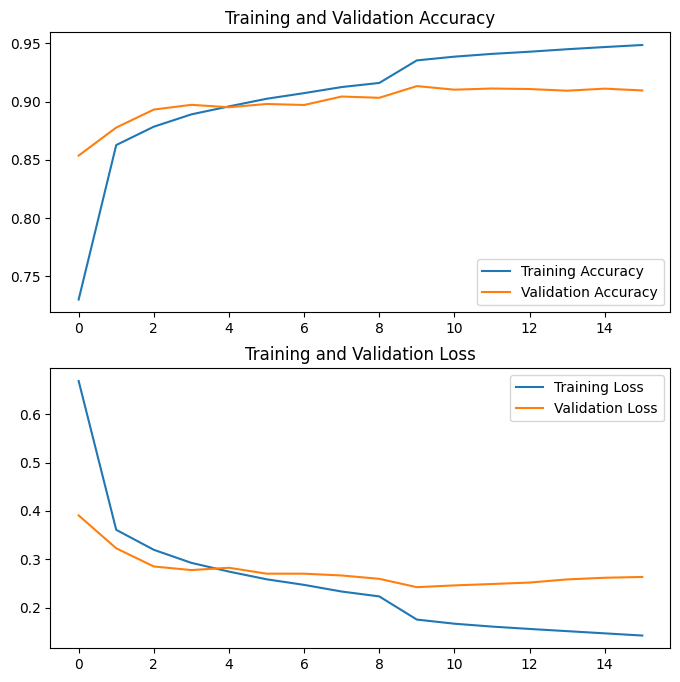

In [29]:
import matplotlib.pyplot as plt

acc = h.history['accuracy']
val_acc = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs_range = range(N_EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1032/1032 [==============================] - 2s 2ms/step
Overall test accuracy: {'Overall': 0.9094848484848485}
16QAM test accuracy: 0.8855704697986577
64QAM test accuracy: 0.9701694915254238
8PSK test accuracy: 0.7571714476317545
B-FM test accuracy: 1.0
BPSK test accuracy: 0.7903711133400201
CPFSK test accuracy: 1.0
DSB-AM test accuracy: 0.9321582973062853
GFSK test accuracy: 0.9848142164781907
PAM4 test accuracy: 0.8853459972862958
QPSK test accuracy: 0.9044756179024717
SSB-AM test accuracy: 0.8886625933469111
[[2639   52  119    0   15    0    2    3   39  111    0]
 [  79 2862    0    0    0    0    0    0    0    9    0]
 [  31    0 2270    0  500    0   48   15   64   70    0]
 [   0    0    0 3009    0    0    0    0    0    0    0]
 [   0    0  376    0 2364    0  172    7   72    0    0]
 [   0    0    0    0    0 3082    0    0    0    0    0]
 [   0    0    3    0  110    0 2803    0    1    0   90]
 [   1    0   22    0   12    0    7 3048    5    0    0]
 [  41    0  102  

(array([[2639,   52,  119,    0,   15,    0,    2,    3,   39,  111,    0],
        [  79, 2862,    0,    0,    0,    0,    0,    0,    0,    9,    0],
        [  31,    0, 2270,    0,  500,    0,   48,   15,   64,   70,    0],
        [   0,    0,    0, 3009,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,  376,    0, 2364,    0,  172,    7,   72,    0,    0],
        [   0,    0,    0,    0,    0, 3082,    0,    0,    0,    0,    0],
        [   0,    0,    3,    0,  110,    0, 2803,    0,    1,    0,   90],
        [   1,    0,   22,    0,   12,    0,    7, 3048,    5,    0,    0],
        [  41,    0,  102,    0,  174,    0,    6,    8, 2610,    6,    1],
        [  94,    1,  173,    0,    9,    0,    2,    0,    7, 2708,    0],
        [   0,    0,    0,    0,    7,    0,  321,    0,    0,    0, 2618]]),
 {'Overall': 0.9094848484848485,
  '16QAM': 0.8855704697986577,
  '64QAM': 0.9701694915254238,
  '8PSK': 0.7571714476317545,
  'B-FM': 1.0,
  'BPSK': 0.7903711133

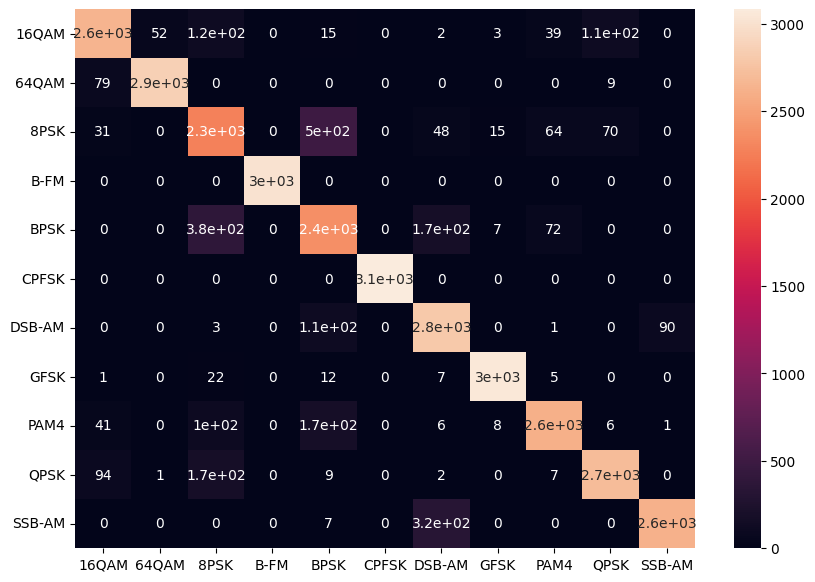

In [30]:
evaluate_model(model, validation_data, validation_labels, verbose=True)

In [31]:
snrs = list(range(0, 30))
def snr_by_idx(idx):
    snr_idx = (idx % 30000) // 1000
    return snrs[snr_idx]

validation_snrs = np.array([snr_by_idx(idx) for idx in validation_indecies])

In [42]:
snr_to_acc = get_snr_to_acc(model, validation_data, validation_labels, validation_indecies)

snr=0
Overall test accuracy: 0.9188458070333634
snr=1
Overall test accuracy: 0.9148148148148149
snr=2
Overall test accuracy: 0.9212880143112702
snr=3
Overall test accuracy: 0.9206212251941329
snr=4
Overall test accuracy: 0.8948811700182815
snr=5
Overall test accuracy: 0.8997214484679665
snr=6
Overall test accuracy: 0.8919156414762741
snr=7
Overall test accuracy: 0.8946378174976481
snr=8
Overall test accuracy: 0.9197080291970803
snr=9
Overall test accuracy: 0.902353966870096
snr=10
Overall test accuracy: 0.9161041465766635
snr=11
Overall test accuracy: 0.9122486288848263
snr=12
Overall test accuracy: 0.9009474590869939
snr=13
Overall test accuracy: 0.9007971656333038
snr=14
Overall test accuracy: 0.9139194139194139
snr=15
Overall test accuracy: 0.9138712601994561
snr=16
Overall test accuracy: 0.906896551724138
snr=17
Overall test accuracy: 0.9056603773584906
snr=18
Overall test accuracy: 0.8938656280428432
snr=19
Overall test accuracy: 0.8984861976847729
snr=20
Overall test accuracy: 0.

(0.0, 1.0)

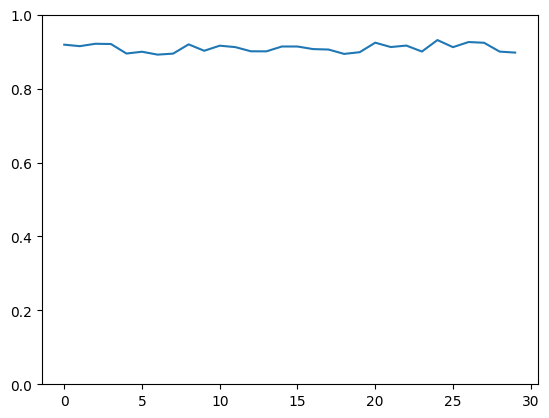

In [43]:
plt.plot(list(snr_to_acc.keys()), list(snr_to_acc.values()))
plt.ylim([0, 1])

In [34]:
len(train_data)

264000